In [1]:
!nvidia-smi

Sat May  8 09:14:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##TODO

1. Pick a Dataset
2. Download a Dataset
3. Import the Dataset
4. Explore the Dataset
5. Prepare the Dataset for training

#Painting Vs Photograph Classification

Mounting `Drive`

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Downloading Dataset

In [3]:
! pip install -q kaggle

In [4]:
 from google.colab import files 
 files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammadhananasghar","key":"a8cc5747df3ed78aa73022e7d127bbbd"}'}

In [5]:
! mkdir ~/.kaggle 

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d iiplutocrat45ii/painting-vs-photograph-classification-dataset

100% 429M/430M [00:05<00:00, 52.2MB/s]
100% 430M/430M [00:05<00:00, 82.4MB/s]


In [9]:
!cp '/content/painting-vs-photograph-classification-dataset.zip' '/content/drive/MyDrive'

In [ ]:
!unzip *.zip && rm -rf *.zip

Checking Dataset

In [1]:
data_train = "/content/train"
data_valid = "/content/valid"

In [2]:
import glob
train_count_images = glob.glob(f'{data_train}/*/*.jpg')
print(len(train_count_images))

7041


In [3]:
valid_count_images = glob.glob(f'{data_valid}/*/*.jpg')
print(len(valid_count_images))

3010


Importing Necessary `Libraries`

In [2]:
import PIL
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

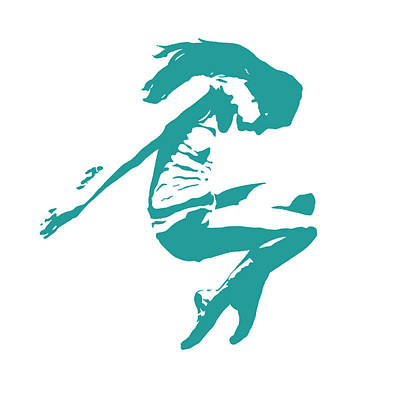

In [5]:
painting = '/content/train/painting/00200fa2c8fd5051dfa19a2e4d6ccb952ef41917.jpg'
PIL.Image.open(painting)

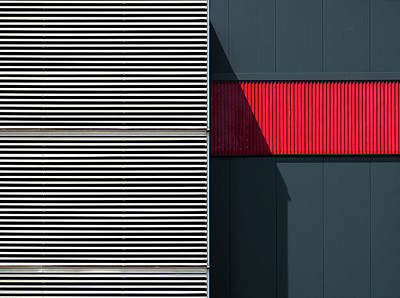

In [6]:
picture = "/content/train/photos/004990b572a148df96cb379ab7b64e43234b125f.jpg"
PIL.Image.open(picture)

In [3]:
batch_size = 64
img_height = 200
img_width = 200

In [45]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_train,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7041 files belonging to 2 classes.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_valid,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3010 files belonging to 2 classes.


In [46]:
class_names = train_ds.class_names
print(class_names)

['painting', 'photos']


`Visualizing and Exploring` Some Data

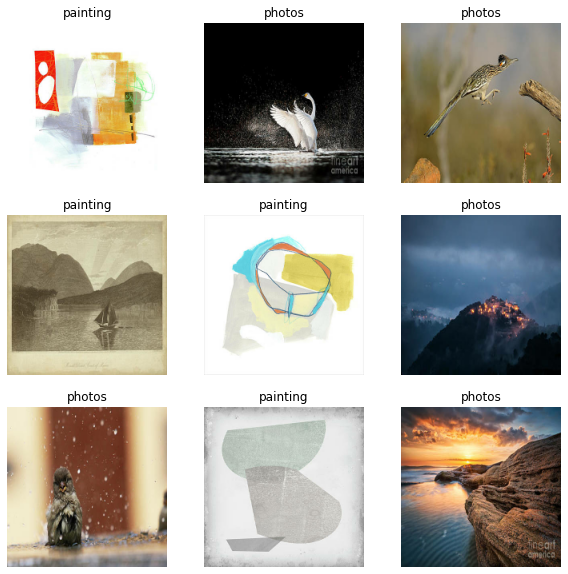

In [26]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 180, 180, 3)
(64,)


`Autotunning` Data

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Data `Augmenting`

In [7]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

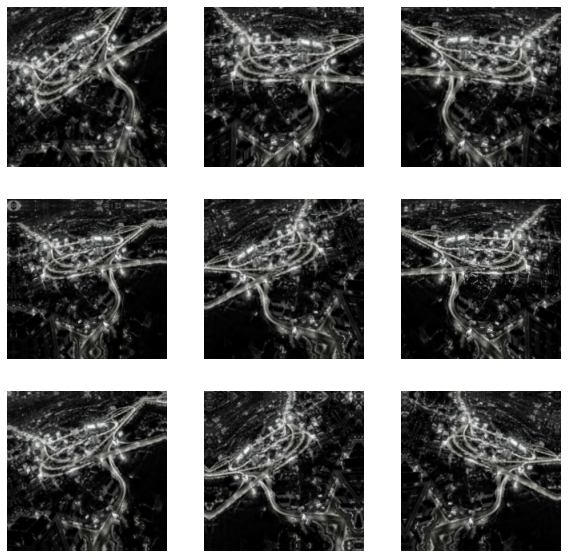

In [31]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [14]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(512, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(1000, activation='relu'),
  layers.Dense(2)
])

In [15]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 200, 200, 3)       0         
_________________________________________________________________
rescaling_4 (Rescaling)      (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 200, 200, 16)      448       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 50, 50, 64)       

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
checkpoint = ModelCheckpoint("model_pvp.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose = 1)

earlystop = EarlyStopping(monitor="val_loss",
                         min_delta=0,
                         patience=3,
                         verbose=1,
                         restore_best_weights=True)

callbacks = [earlystop, checkpoint]

In [18]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks,
)

Epoch 1/50
111/111 [==============================] - 27s 109ms/step - loss: 0.7415 - accuracy: 0.5885 - val_loss: 0.5762 - val_accuracy: 0.6860

Epoch 00001: val_loss improved from inf to 0.57619, saving model to model_pvp.h5
Epoch 2/50
111/111 [==============================] - 7s 63ms/step - loss: 0.5864 - accuracy: 0.6870 - val_loss: 0.5591 - val_accuracy: 0.7063

Epoch 00002: val_loss improved from 0.57619 to 0.55914, saving model to model_pvp.h5
Epoch 3/50
111/111 [==============================] - 7s 63ms/step - loss: 0.5551 - accuracy: 0.7126 - val_loss: 0.5408 - val_accuracy: 0.7299

Epoch 00003: val_loss improved from 0.55914 to 0.54078, saving model to model_pvp.h5
Epoch 4/50
111/111 [==============================] - 7s 64ms/step - loss: 0.5428 - accuracy: 0.7184 - val_loss: 0.6741 - val_accuracy: 0.6455

Epoch 00004: val_loss did not improve from 0.54078
Epoch 5/50
111/111 [==============================] - 7s 64ms/step - loss: 0.5609 - accuracy: 0.7127 - val_loss: 0.5262 

`Visualizing` Model Stats

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

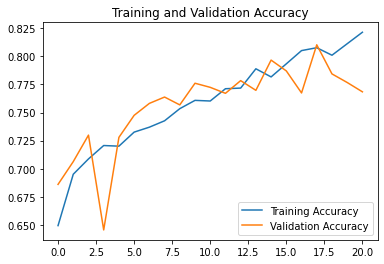

In [28]:
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

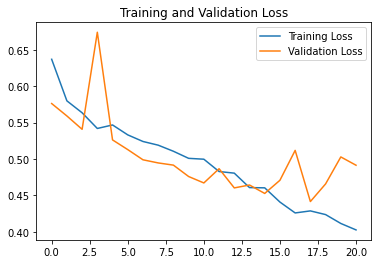

In [29]:
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

`Prediction` From our Trained Model

This image most likely belongs to photos with a 89.07 percent confidence.


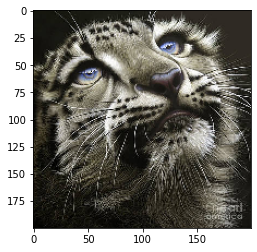

In [47]:
img = keras.preprocessing.image.load_img(
    '/content/test/5021.jpg', target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to photos with a 88.65 percent confidence.


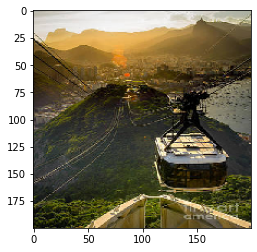

In [48]:
img = keras.preprocessing.image.load_img(
    '/content/test/5121.jpg', target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to painting with a 98.51 percent confidence.


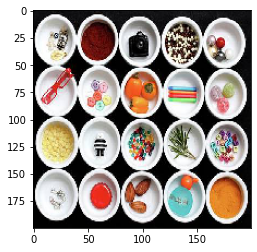

In [49]:
img = keras.preprocessing.image.load_img(
    '/content/valid/photos/06b2b2d62a56d2b597f20789a124b8073ac4b1e1.jpg', target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to photos with a 99.25 percent confidence.


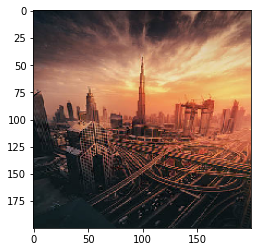

In [50]:
img = keras.preprocessing.image.load_img(
    '/content/valid/photos/04c9836482a60fc14abb0240330f8f3194c84f61.jpg', target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)